# Import Required Libraries
Import the necessary libraries, including TensorFlow, pandas, and NumPy.

In [11]:
# Import the necessary libraries
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import time

# Load the WikiQA Dataset
Load the WikiQA Corpus dataset into a pandas DataFrame.

In [12]:
# Load the dataset into a pandas DataFrame
wikiqa_df = pd.read_csv("wikiqa.csv")

In [13]:
# Display the first few rows of the dataset to understand its structure
wikiqa_df.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-0,African immigration to the United States refer...,0
1,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-1,The term African in the scope of this article ...,0
2,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-2,From the Immigration and Nationality Act of 19...,0
3,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-3,African immigrants in the United States come f...,0
4,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-4,"They include people from different national, l...",0


# Explore the Dataset
Perform basic exploratory data analysis (EDA) to understand the structure and content of the dataset.

In [14]:
# Display basic information about the dataset
wikiqa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29208 entries, 0 to 29207
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   QuestionID     29208 non-null  object
 1   Question       29208 non-null  object
 2   DocumentID     29208 non-null  object
 3   DocumentTitle  29208 non-null  object
 4   SentenceID     29208 non-null  object
 5   Sentence       29208 non-null  object
 6   Label          29208 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [15]:
# Display summary statistics of the dataset
wikiqa_df.describe()

,Label
count,29208.000000
mean,0.050294
std,0.218556
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [16]:
# Check for missing values in the dataset
wikiqa_df.isnull().sum()

QuestionID       0
Question         0
DocumentID       0
DocumentTitle    0
SentenceID       0
Sentence         0
Label            0
dtype: int64

<Axes: title={'center': 'Distribution of Labels'}, xlabel='Label'>

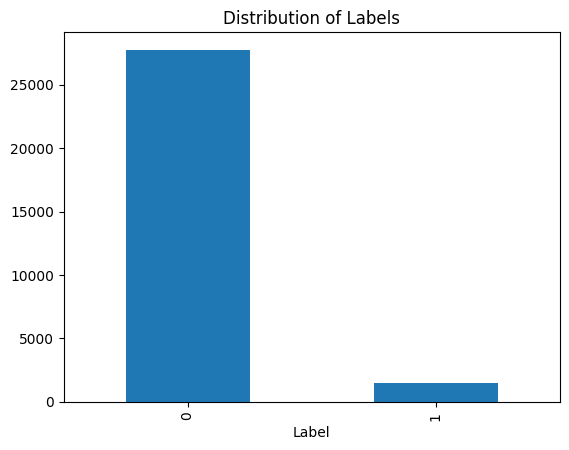

In [18]:
# Display the distribution of the target variable
wikiqa_df['Label'].value_counts().plot(kind='bar', title='Distribution of Labels')

In [19]:
# Display the unique questions in the dataset
unique_questions = wikiqa_df['Question'].nunique()
print(f'Number of unique questions: {unique_questions}')

Number of unique questions: 3044


In [20]:
# Display the unique sentences in the dataset
unique_sentences = wikiqa_df['Sentence'].nunique()
print(f'Number of unique sentences: {unique_sentences}')

Number of unique sentences: 26166


In [21]:
# Display the average number of sentences per question
avg_sentences_per_question = wikiqa_df.groupby('Question')['Sentence'].count().mean()
print(f'Average number of sentences per question: {avg_sentences_per_question}')

Average number of sentences per question: 9.59526938239159


In [23]:
# Check for duplicate questions in the dataset
duplicate_questions = wikiqa_df['Question'].duplicated().sum()
print(f'Number of duplicate questions: {duplicate_questions}')

Number of duplicate questions: 26164


In [24]:
# Check for duplicate sentece in the dataset
duplicate_sentences = wikiqa_df['Sentence'].duplicated().sum()
print(f'Number of duplicate sentences: {duplicate_sentences}')

Number of duplicate sentences: 3042


# Preprocess the Data
Preprocess the data by cleaning and tokenizing the text.

In [26]:
# Preprocess the Data

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply the cleaning function to the questions and sentences
wikiqa_df['cleaned_question'] = wikiqa_df['Question'].apply(clean_text)
wikiqa_df['cleaned_sentence'] = wikiqa_df['Sentence'].apply(clean_text)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(wikiqa_df['cleaned_question'].tolist() + wikiqa_df['cleaned_sentence'].tolist())

# Convert text to sequences
question_sequences = tokenizer.texts_to_sequences(wikiqa_df['cleaned_question'].tolist())
sentence_sequences = tokenizer.texts_to_sequences(wikiqa_df['cleaned_sentence'].tolist())

# Pad the sequences
max_length = max(max(len(seq) for seq in question_sequences), max(len(seq) for seq in sentence_sequences))
question_padded = pad_sequences(question_sequences, maxlen=max_length, padding='post')
sentence_padded = pad_sequences(sentence_sequences, maxlen=max_length, padding='post')

# Display the first few rows of the cleaned and tokenized data
print(question_padded[:5])
print(sentence_padded[:5])

[[ 12 568 520 ...   0   0   0]
 [ 12 568 520 ...   0   0   0]
 [ 12 568 520 ...   0   0   0]
 [ 12 568 520 ...   0   0   0]
 [ 12 568 520 ...   0   0   0]]
[[ 568 1422    8 ...    0    0    0]
 [   1  128  568 ...    0    0    0]
 [  18    1 1422 ...    0    0    0]
 [ 568 2035    3 ...    0    0    0]
 [  70  165   75 ...    0    0    0]]


# Take 10% Sample of the Data
Randomly select 10% of the dataset to test training speed and feasibility.

In [ ]:
# Take 10% Sample of the Data

# Set the random seed for reproducibility
np.random.seed(42)

# Calculate the sample size (10% of the dataset)
sample_size = int(len(wikiqa_df) * 0.1)

# Randomly select 10% of the dataset
sampled_df = wikiqa_df.sample(n=sample_size)

# Tokenize the sampled text
sampled_question_sequences = tokenizer.texts_to_sequences(sampled_df['cleaned_question'].tolist())
sampled_sentence_sequences = tokenizer.texts_to_sequences(sampled_df['cleaned_sentence'].tolist())

# Pad the sampled sequences
sampled_question_padded = pad_sequences(sampled_question_sequences, maxlen=max_length, padding='post')
sampled_sentence_padded = pad_sequences(sampled_sentence_sequences, maxlen=max_length, padding='post')

# Display the first few rows of the cleaned and tokenized sampled data
print(sampled_question_padded[:5])
print(sampled_sentence_padded[:5])

[[  12   43  140 ...    0    0    0]
 [  17  353    1 ...    0    0    0]
 [   7    5 3743 ...    0    0    0]
 [  26    9    1 ...    0    0    0]
 [  22   24    1 ...    0    0    0]]
[[   99  4089 10027 ...     0     0     0]
 [    3    93     4 ...     0     0     0]
 [  261     2  1649 ...     0     0     0]
 [    1    93     9 ...     0     0     0]
 [ 1368    83     5 ...     0     0     0]]


In [28]:
# Display the first few rows of the sampled DataFrame to verify
sampled_df.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label,cleaned_question,cleaned_sentence
5225,Q514,how do you know if a volcano is extinct,D179,Volcano,D179-9,"These so-called "" hotspots "", for example Hawa...",0,how do you know if a volcano is extinct,these socalled hotspots for example hawaii a...
17785,Q1804,"Who wrote the song, ""Just the Way You Are""",D1706,Just the Way You Are,D1706-9,In film and television:,0,who wrote the song just the way you are,in film and television
22709,Q2332,what is hdmi out,D2195,HDMI,D2195-7,Production of consumer HDMI products started i...,0,what is hdmi out,production of consumer hdmi products started i...
27558,Q2861,where was the movie unstoppable directed,D2655,Unstoppable (2010 film),D2655-5,The film was nominated for an Academy Award fo...,0,where was the movie unstoppable directed,the film was nominated for an academy award fo...
12311,Q1229,when did the trojan war take place,D1177,Trojan War,D1177-16,Whether there is any historical reality behind...,0,when did the trojan war take place,whether there is any historical reality behind...


# Build a Simple TensorFlow Model
Build a simple TensorFlow model for question answering using the sampled data.

In [31]:
# Build a Simple TensorFlow Model

# Define the input layers
question_input = Input(shape=(max_length,), dtype='int32', name='question_input')
sentence_input = Input(shape=(max_length,), dtype='int32', name='sentence_input')

# Define the embedding layer
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length)

# Embed the inputs
question_embedding = embedding_layer(question_input)
sentence_embedding = embedding_layer(sentence_input)

# Define the LSTM layers
shared_lstm = LSTM(64)

# Process the embeddings with the LSTM layers
question_lstm = shared_lstm(question_embedding)
sentence_lstm = shared_lstm(sentence_embedding)

# Concatenate the LSTM outputs
merged = Concatenate()([question_lstm, sentence_lstm])

# Define the output layer
output = Dense(1, activation='sigmoid')(merged)

# Build the model
model = Model(inputs=[question_input, sentence_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Prepare the labels
labels = sampled_df['Label'].values

# Train the model on the sampled data
model.fit([sampled_question_padded, sampled_sentence_padded], labels, epochs=5, batch_size=32, validation_split=0.2)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ question_input      │ (None, 996)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentence_input      │ (None, 996)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 996, 128)  │  4,957,056 │ question_input[0… │
│ (Embedding)         │                   │            │ sentence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ embedding_2[0][0… │
│                     │                   │            │ embedding_2[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ lstm_2[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,006,593 (19.10 MB)

 Trainable params: 5,006,593 (19.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.9507 - loss: 0.2772 - val_accuracy: 0.9521 - val_loss: 0.1924
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 352ms/step - accuracy: 0.9540 - loss: 0.1884 - val_accuracy: 0.9521 - val_loss: 0.1924
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 384ms/step - accuracy: 0.9543 - loss: 0.1860 - val_accuracy: 0.9521 - val_loss: 0.1925
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 375ms/step - accuracy: 0.9544 - loss: 0.1862 - val_accuracy: 0.9521 - val_loss: 0.1927
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 28s 379ms/step - accuracy: 0.9545 - loss: 0.1862 - val_accuracy: 0.9521 - val_loss: 0.1930


# Evaluate Training Speed and Feasibility
Train the model on the sampled data and evaluate the training speed and feasibility.

Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 363ms/step - accuracy: 0.9490 - loss: 0.2015 - val_accuracy: 0.9521 - val_loss: 0.1924
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 362ms/step - accuracy: 0.9475 - loss: 0.2068 - val_accuracy: 0.9521 - val_loss: 0.1936
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 361ms/step - accuracy: 0.9587 - loss: 0.1744 - val_accuracy: 0.9521 - val_loss: 0.1924
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 26s 359ms/step - accuracy: 0.9500 - loss: 0.1992 - val_accuracy: 0.9521 - val_loss: 0.1929
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 371ms/step - accuracy: 0.9503 - loss: 0.1985 - val_accuracy: 0.9521 - val_loss: 0.1927
Training duration: 132.54914689064026 seconds
Validation Loss: 0.189545139670372
Validation Accuracy: 0.9530822038650513


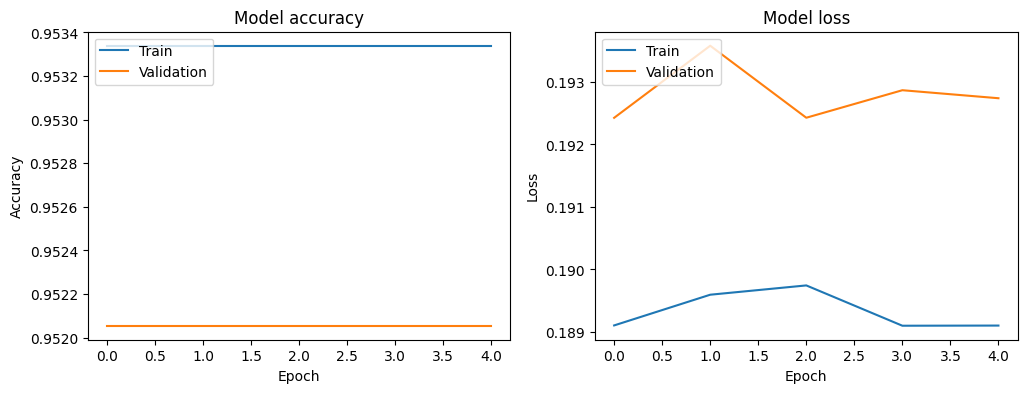

In [32]:
# Evaluate Training Speed and Feasibility

# Record the start time
start_time = time.time()

# Train the model on the sampled data
history = model.fit([sampled_question_padded, sampled_sentence_padded], labels, epochs=5, batch_size=32, validation_split=0.2)

# Record the end time
end_time = time.time()

# Calculate the training duration
training_duration = end_time - start_time
print(f'Training duration: {training_duration} seconds')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate([sampled_question_padded, sampled_sentence_padded], labels, verbose=0)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()